In [6]:
import pandas as pd

df = pd.read_csv('./out/replay_results.csv', index_col=[0, 1])
df

reward
                 date                   
E-Greedy-AutoRec 2024-10-01   149.661667
                 2024-10-02   309.928333
                 2024-10-03   416.566944
                 2024-10-04   525.940278
                 2024-10-05   642.031944
...                                  ...
E-Greedy-Mean    2024-11-03  3099.398997
                 2024-11-04  3186.593163
                 2024-11-05  3273.057330
                 2024-11-06  3357.893719
                 2024-11-07  3451.568997

[152 rows x 1 columns]

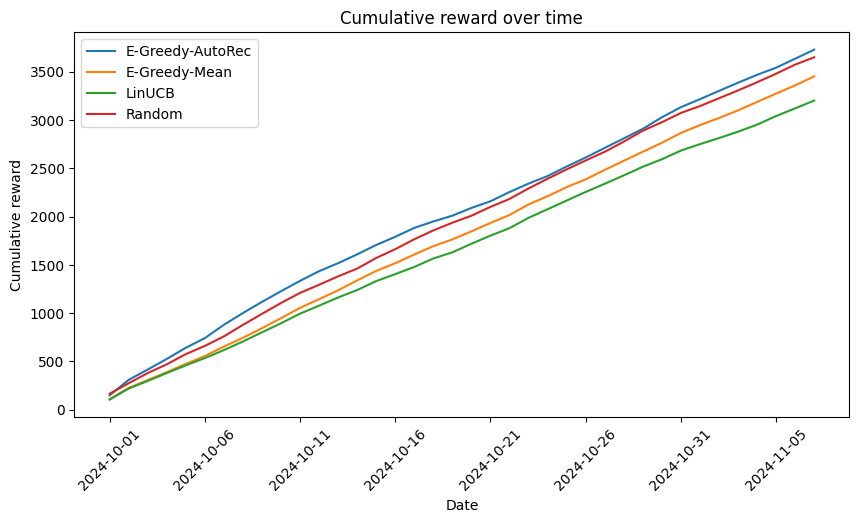

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for name, group in df.groupby(level=0):
    plt.plot(group.index.get_level_values(1), group.mean(axis=1), label=name)
    plt.fill_between(group.index.get_level_values(1), group.mean(axis=1) - group.std(axis=1), group.mean(axis=1) + group.std(axis=1), alpha=0.2)

plt.title('Cumulative reward over time')
plt.ylabel('Cumulative reward')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.show()